In [2]:
import os, sys
sys.path.insert(0, '../db-processing')
import psycopg2
import configparser
import argparse
import json
from copy import deepcopy
from html_parser import DBHTMLParser
from collections import defaultdict, Counter

# steps to create from file
1. `psql`
2. `DROP DATABASE collected_ads;`
3. `psql template1 -c 'create database collected_ads with owner piotr;'`
4. `psql collected_ads < collected_ads_20210628.sql`

Dorota's id: `'neu:7746f9ac-fd28-4d62-b28a-08f8cc60fa00'`

In [63]:
DOROTA = 'neu:7746f9ac-fd28-4d62-b28a-08f8cc60fa00'

In [5]:
def setup():
    CONFIG_FILE = "../db-processing/config.local.ini"
    if not os.path.isfile(CONFIG_FILE):
        print(f"Config file is missing: {CONFIG_FILE}")
        sys.exit()

    Config = configparser.ConfigParser()
    Config.read(CONFIG_FILE)
    # db config settings
    db_user = Config.get("database", "user")
    db_port = Config.get("database", "port")
    db_database = Config.get("database", "db")
    db_schema = Config.get("database", "schema")
    db_password = Config.get("database", "password")
    # filesystem config settings
    image_data_path = Config.get("filesystem", "images")
    observation_data_path = Config.get("filesystem", "observations")
    # connect to db and set search_path
    if len(db_password):
        conn = psycopg2.connect(f"dbname='{db_database}' user='{db_user}' port='{db_port}' password='{db_password}'")
    else:
        # this would happen for local connections
        conn = psycopg2.connect(f"dbname='{db_database}' user='{db_user}' port='{db_port}'")
    cursor = conn.cursor()
    cursor.execute(f"SET search_path TO '{db_schema}';")
    
    cursor.execute("ALTER TABLE targetings\
                    ALTER COLUMN ad_id TYPE bigint\
                    USING ad_id::bigint;")
    
    return cursor

In [7]:
cursor = setup()

In [8]:
cursor.execute(f"SELECT * FROM observations ")
observations = cursor.fetchall()
dates = defaultdict(set)
for observation in observations:
    dates[str(observation[2])[:10]].add(observation[1])

In [10]:
cursor.execute(f"SELECT * FROM ads ")
all_ads = cursor.fetchall()

In [11]:
ad_content = {}
for ad in all_ads:
    ad_content[ad[0]] = ad[2].replace('\n', '')
    
    

In [12]:
cursor.execute("SELECT ad_id,instid FROM observations;")
result = cursor.fetchall()
ad_id2user = defaultdict(set)
for mapping in result:
    ad_id2user[mapping[0]].add(mapping[1])
    if len(ad_id2user[mapping[0]]) > 1:
        print(mapping[0])
    

6233283645787
23847574201500787
23847356524490423
6233283645787
6233283645787
6233283645787
6233283645787
23847356524490423
23847571411330750
23847574201500787
6233283645787
6233283645787
6233283645787


In [14]:
per_user_targetings = defaultdict(list)
cursor.execute(f"SELECT * FROM targetings")
participant_q_result = cursor.fetchall()
for targeting in participant_q_result:
    users = ad_id2user[targeting[0]]
    for user in users:
        per_user_targetings[user].append(targeting)
        
        

In [18]:
per_user_targetings

defaultdict(list,
            {'neu:616d9b9d-b102-4103-b939-a8884f961d89': [(23847411696390161,
               None,
               None,
               None,
               None,
               '{"data":{"waist_targeting_data":[{"__typename":"WAISTUILocaleType","__isIWAISTUIType":"WAISTUILocaleType","id":"V0FJU1RVSUxvY2FsZVR5cGU6MjQuNg==","serialized_data":"{\\"locales\\":[24,6]}","waist_ui_type":"LOCALE","locales":["English (UK)","English (US)"]},{"__typename":"WAISTUIAgeGenderType","__isIWAISTUIType":"WAISTUIAgeGenderType","id":"V0FJU1RVSUFnZUdlbmRlclR5cGU6NjUz","serialized_data":"{\\"age_min\\":6,\\"age_max\\":53,\\"gender\\":null}","waist_ui_type":"AGE_GENDER","age_min":6,"age_max":53,"gender":"ANY"},{"__typename":"WAISTUILocationType","__isIWAISTUIType":"WAISTUILocationType","id":"V0FJU1RVSUxvY2F0aW9uVHlwZTpjb3VudHJ5LmhvbWUuVVM=","serialized_data":"{\\"location_granularity\\":\\"country\\",\\"location_geo_type\\":\\"home\\",\\"location_code\\":\\"US\\"}","waist_ui_type":"LOCATION

In [75]:
def get_interests(user_targetings):
    interest_counter = []
    for ad in user_targetings:
        if ad[1] is None:
            interest_counter.append(ad[1])
            continue
        interest = json.loads(ad[1])
        for i in interest:
            interest_counter.append(i['name'])
    return(Counter(interest_counter))
    

In [76]:
for user in per_user_targetings.keys():
    if user == 'neu:7746f9ac-fd28-4d62-b28a-08f8cc60fa00': continue
    print(get_interests(per_user_targetings[user]).most_common(10))
    print()
    

[(None, 1)]

[(None, 123), ('Overwatch (video game)', 6), ('Video games', 6), ('PC Gamer', 6), ('Fortnite', 5), ('Streaming media', 4), ('Ultimate Fighting Championship', 4), ('Boxing', 4), ('Conor McGregor', 3), ('Mixed martial arts', 3)]

[(None, 31), ('Charitable organization', 2), ('Tourism', 1), ('Cruises', 1), ('E-commerce', 1), ('Hobbies and activities', 1), ('Video games', 1), ('Camping World', 1), ('RV Trader', 1)]

[(None, 355), ('Shopping and fashion', 6), ('Online shopping', 5), ('Fashion accessories', 4), ('Jewelry', 4), ('Shopping', 4), ('Books', 3), ('Sephora', 3), ('Beauty', 3), ('The New Yorker', 3)]

[(None, 61), ('Discount stores', 2), ('Pop music', 2), ('Prince (musician)', 1), ('Seal (musician)', 1), ('Beyoncé', 1), ('Alicia Keys', 1), ('Tina Turner', 1), ('Whitney Houston', 1), ('Marvin Gaye', 1)]

[(None, 11)]

[(None, 42), ('Hobbies and activities', 1), ('Food and drink', 1), ('Cosmetics', 1)]

[(None, 1)]



In [77]:
(set(get_interests(per_user_targetings[DOROTA])))


{'Academy Awards',
 'Acting',
 'Action films',
 'Adventure travel',
 'Aesthetics',
 'Air travel',
 'Alcoholic drink',
 'Allegro (auction website)',
 'American football',
 'Animated films',
 'Anime films',
 'Architects',
 'Architectural style',
 'Architecture',
 'Art museums',
 'Arts and music',
 'Audio equipment',
 'Autism Awareness',
 'BBC',
 'Barbecue',
 'Baseball',
 'Basketball',
 'Beaches',
 'Beauty',
 'Beauty salons',
 'Berlin',
 'Big data',
 'Birds',
 'Blog',
 'Bloomberg',
 'Blouse',
 'Blues music',
 'Board games',
 'Bollywood films',
 'Booking.com',
 'Books',
 'Boutiques',
 'Breastfeeding',
 'Breathing',
 'Business',
 'Business Insider',
 'Business and industry',
 'Camcorders',
 'Cameras',
 'Canapé (furniture)',
 'Cancer awareness',
 'Car racing',
 'Car rentals',
 'Carpentry',
 'Casino games',
 'Catholic Church',
 'Cats',
 'Child',
 'Childbirth',
 'Childhood',
 "Children's clothing",
 'Chocolate',
 'Classical music',
 'Clothing',
 'College football',
 'Comedy films',
 'Comics',


In [115]:
interests = {

'ENTERTAINMENT' : set({'Academy Awards',
 'Acting',
 'Action films',
 'Animated films','Anime films','Arts and music',
 'Audio equipment','Blues music',
 'Board games',
 'Bollywood films','Books','Camcorders',
 'Cameras','Casino games','Classical music','Comedy films',
 'Comics','Concerts','Country music','Crafts','Culture','DIY','Dance',
 'Dance music','Do it yourself (DIY)','Documentary films','Drama films','Drums','Electronic music',
 'Entertainment','Fantasy films','Fiction books',
 'Films', 'Gambling',
 'Game consoles','Gospel music','Guitar','Heavy metal music','Hip hop music',
 'Hobbies and activities',
 'Hobby','Holidays','Horror films','Jazz music','Lakes','Literature','Magazines','Metric (band)',
 'Minimal techno',
 'Movie theater','Music',
 'Music festivals',
 'Music videos',
 'Musical theatre','Netflix','Nikon','Online games','Optics','Parties',
 'Performing arts','Philosophy',
 'Photography','Podcast','Pop music','Radio',
 'Reading','Rhythm and blues music',
 'Rock music','Science',
 'Science fiction films','Shape (magazine)','Singing','Soul music', 'Thriller films', 'Video games',
 'Writing','eBooks','Drawing','Kids (film)','World of Warcraft','Humour'
 }), 
                    
'TRAVEL' : set({'Adventure travel','Air travel','Beaches','Berlin','Booking.com','Car rentals','Cruises',
             'Ecotourism','Forest','Gdańsk','Hotels','Italy','Mountains','National Geographic (magazine)',
 'Nature','Podróże',
 'Poland',
 'Polish language','Poznań','Russia','Salon (Paris)','Spain','Theme parks','Tourism','Travel','TripAdvisor',
             'Ukraine',
 'United States','Warsaw','Wrocław','Ocean'}),

'DESIGN_ARCHITECTURE' : set({'Aesthetics','Architects','Architectural style','Architecture',
 'Art museums','Canapé (furniture)','Decorative arts','Design',
 'Designers','Fine art','Graphic design','Interior design','Painting','Sculpture','Visual arts',
                             'Modern architecture','Carpentry'}),

'SHOPPING_FASHION_BEAUTY' : set({'Allegro (auction website)','Beauty',
 'Beauty salons','Blouse','Boutiques','Clothing','Cosmetics','Coupons','Decathlon Group',
 'Discount shops','Dresses','Fashion (film)',
 'Fashion accessories',
 'Fashion design','Fragrances','Furniture','H&M',
 'Hair products',
 'Handbags','IKEA','Jewellery','KappAhl', 'Lidl',
 'Lidl Polska','Luxury goods',
 "Men's clothing",'Money','New Balance','Online shopping','Reserved','Retail',
 'Retro style','Shoes','Shopping',
 'Shopping Online - Clothes',
 'Shopping and fashion',
 'Shopping centres','Sinsay','Skirt','Sunglasses','Tattoos','Vogue (magazine)',"Women's clothing",'Zalando',
 'Zara (retailer)','Elle (magazine)','Glamour (magazine)',}),

'REAL_ESTATE_HOME_OWNERSHIP' : set({'Real estate investing','Property','Construction','Door','Home',
 'Home Office',
 'Home and garden','House','Luxury property','Modern furniture', 'Flat','Financial adviser'}),

'ALCOHOL' : set({'Alcoholic drink','Wine','Żywiec Brewery'}),

'NEWS' : set({'Business',
 'Business Insider',
 'Business and industry','BBC','Bloomberg','Blog','Current events','Dzień Dobry TVN','Gazeta Wyborcza',
'Information','Journalism',
 'Journalist','Mass media','Newspapers',
 'Newsweek Polska','Onet.pl','Polityka','TVN (Poland)',
 'TVP Info','Telewizja Polska','The Economist',
 'The Wall Street Journal',
 'The Washington Post','Life'}),

'FOOD' : set({'Barbecue','Chocolate','Desserts','Eating','Meat','Organic food','Pizza',
 'Plant','Seafood','Subway (restaurant)','Veganism',
 'Vegetables',
 'Vegetarianism','Fast food','Fish','Food',
 'Food and drink','Fruit'}),

'ACTIVISM_POLICY' : set({'Catholic Church', 'Non-governmental organization',
 'Non-profit organisation','Politics',
 'Politics and social issues', 'UNICEF','Volunteering',"Women's rights",'Ecology',
                       'European Union','Feminism','Foundation (non-profit)',
                      'Human rights','LGBT community','Law','Lawyer','Religion','Liberty'}),

'ANIMALS' : set({'Birds','Cats','Dogs','Pet food',
 'Pets','Rabbits','Reptiles','Horses'}),

'EDUCATION_SCIENCE' : set({'Education', 'University','Engineering','Higher education',
                        'Knowledge','Management','Student'}),

'OTHER' : set({'Emotion','English language','Euro',
             'Glass','Light','Sun','Water','Woman','Wood', 'Workweek and weekend',}),

'SPORT' : set({'American football','Baseball',
 'Basketball','Car racing','College football','Football','Golf','Marathons','Skiing','Snowboarding','Specialized Bicycle Components',
 'Sports',
 'Sports and outdoors',
 'Sports club',
 'Sports games',
 'Sportswear (activewear)','Swimming','Tennis','Triathlons','Volleyball',}),


    
'PARENTING': set({'Autism Awareness','Breastfeeding','Child','Childbirth',
 'Childhood',
 "Children's clothing",'Developmental psychology','Fatherhood','Infant',
 'Infante','Kindergarten','Maria Montessori','Montessori education',
 'Motherhood','Nappy','Pampers',
 'Parent','Pregnancy',
 'Pregnancy (mammals)','Toys'}),
    
'HEALTH': set({'Breathing','Cancer awareness','Dietitian','Doctor (title)',
              'Fitness and wellness','Healthcare','Hospital','Intensive care unit',
              'Magnetic resonance imaging','Medicine','Muscle','Neoplasm','Oncology',
              'Pfizer','Physical exercise','Physical fitness','Physician','Psychiatry',
  'Psychologist',
  'Psychology','Respiratory system','Sauna','Spas','Therapy','Wedding reception',
  'Weight loss (Fitness And wellness)'}),
    
'RELATIONSHIP': set({'Family',
  'Family and relationships','Human sexuality','Love','Wife'}),
  
# 'HEALTH_PARENTING' : set({'Autism Awareness','Breastfeeding',
#  'Breathing','Cancer awareness','Child',
#  'Childbirth',
#  'Childhood',
#  "Children's clothing",'Developmental psychology',
#  'Dietitian','Doctor (title)','Family',
#  'Family and relationships','Fatherhood','Fitness and wellness','Healthcare','Hospital','Infant',
#  'Infante','Intensive care unit',
#  'Kindergarten','Human sexuality','Love','Magnetic resonance imaging','Maria Montessori','Medicine',
#   'Montessori education',
#  'Motherhood','Muscle','Nappy','Neoplasm','Oncology','Pampers',
#  'Parent','Pfizer','Physical exercise',
#  'Physical fitness',
#  'Physician','Pregnancy',
#  'Pregnancy (mammals)','Psychiatry',
#  'Psychologist',
#  'Psychology','Respiratory system','Sauna','Spas',
#                        'Therapy','Toys','Wedding reception',
#  'Weight loss (Fitness And wellness)',
#  'Wife',}),


'TECH' : set({'Big data','Computer memory',
 'Computer monitors',
 'Computer processors',
 'Computer science',
 'Computer servers',
 'Computers','Desktop computers','Digital marketing','Display advertising','Email marketing','Facebook','Free software',
 'Freedom of speech','GPS devices','Hard drives','Instagram','Mobile phones',
           'Network storage','Online',
 'Online advertising','Portable media players','Projectors','Search engine optimisation','Smartphones',
           'Social media',
 'Social media marketing',
 'Social network',
 'Software','Streaming media','Tablet computers','Technology',
 'Televisions','Tik Tok','Web design',
 'Web development',
 'Web hosting','YouTube','eBook readers','eCommerce',})}


In [116]:
interest_to_category = {}
for category, interest_group in interests.items():
    for interest in interest_group:
        interest_to_category[interest] = category

In [119]:
ads = {}
for idx, targeting in enumerate(per_user_targetings[DOROTA]):
    if targeting[-1] is None:
        ads[targeting[0]] = None 
    else:
        waist = json.loads(targeting[-1])
        for el in waist['data']['waist_targeting_data']:
            if el['__typename'] == 'WAISTUIInterestsType':
                ads[targeting[0]] = set([interest_to_category[i['name']] for i in el['interests']])
                break
                
            

In [120]:
ads

{23847918029280230: {'PARENTING'},
 23843197058450346: {'PARENTING', 'RELATIONSHIP'},
 6228165837700: {'DESIGN_ARCHITECTURE', 'SHOPPING_FASHION_BEAUTY'},
 23847997024970318: {'DESIGN_ARCHITECTURE',
  'EDUCATION_SCIENCE',
  'ENTERTAINMENT',
  'NEWS',
  'REAL_ESTATE_HOME_OWNERSHIP',
  'SHOPPING_FASHION_BEAUTY',
  'TECH'},
 23848031527550250: {'DESIGN_ARCHITECTURE',
  'ENTERTAINMENT',
  'REAL_ESTATE_HOME_OWNERSHIP',
  'RELATIONSHIP',
  'SHOPPING_FASHION_BEAUTY'},
 23847144777600570: {'SHOPPING_FASHION_BEAUTY'},
 23847301278400451: {'DESIGN_ARCHITECTURE', 'REAL_ESTATE_HOME_OWNERSHIP'},
 23847414014410048: {'FOOD', 'TRAVEL'},
 6238900237544: {'ACTIVISM_POLICY', 'DESIGN_ARCHITECTURE', 'FOOD', 'TRAVEL'},
 23847297399970159: {'ENTERTAINMENT',
  'PARENTING',
  'RELATIONSHIP',
  'SHOPPING_FASHION_BEAUTY'},
 23847545790660564: {'DESIGN_ARCHITECTURE', 'SHOPPING_FASHION_BEAUTY'},
 23847402415950076: {'DESIGN_ARCHITECTURE',
  'ENTERTAINMENT',
  'SHOPPING_FASHION_BEAUTY'},
 23847310974320291: {'PAREN

In [121]:
interests_over_time = defaultdict(list)
for date in dates:
    for observation in dates[date]:
        try:
            interests_over_time[date].append(ads[observation])
        except:
            interests_over_time[date].append(None)
            

In [122]:
def has_dziecko(ad_text):
    keywords = ["dziec", "dzieć", "synek", "cór", "maleń", "pociech", "przedszk"
               "matk", "ojc", "rodzic"]
    for k in keywords:
        if k in ad_text.lower():
            return True
    return False

dziecko_over_time = defaultdict(list)
for date in dates:
    for observation in dates[date]:
        dziecko_over_time[date].append(has_dziecko(ad_content[observation]))
        

Text(0, 0.5, 'Ad count')

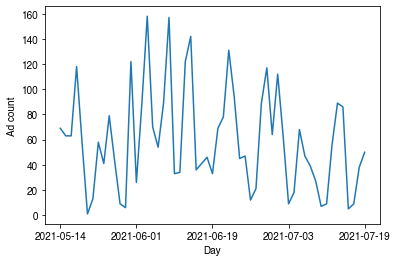

In [123]:
import matplotlib.pyplot as plt
plt.plot([len(interests_over_time[day]) 
          for day in sorted(interests_over_time)])
plt.xticks(range(0, len(interests_over_time), 14), (sorted(interests_over_time.keys())[::14]))
plt.xlabel('Day')
plt.ylabel('Ad count')

Text(0, 0.5, 'Fraction of ads refering to children/parenting')

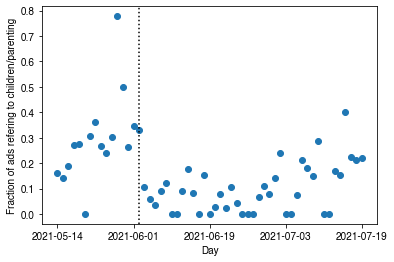

In [234]:
import matplotlib.pyplot as plt
plt.plot([sum(dziecko_over_time[day])/len(interests_over_time[day])
          for day in sorted(dziecko_over_time)], ls='', marker='o')
plt.xticks(range(0, len(dziecko_over_time), 14), (sorted(dziecko_over_time.keys())[::14]))
plt.axvline(15, ls=':', color='k', label='"Parenting" disabled')
plt.xlabel('Day')
plt.ylabel('Fraction of ads refering to children/parenting')

Text(0, 0.5, 'Fraction of ads targeted by interests')

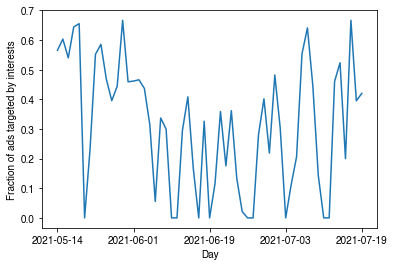

In [125]:
import matplotlib.pyplot as plt
plt.plot([sum([ad is not None for ad in interests_over_time[day]])/len(interests_over_time[day]) 
          for day in sorted(interests_over_time)])
plt.xticks(range(0, len(interests_over_time), 14), (sorted(interests_over_time.keys())[::14]))
plt.xlabel('Day')
plt.ylabel('Fraction of ads targeted by interests')

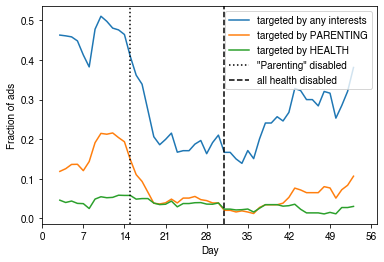

In [131]:
import matplotlib.pyplot as plt
import numpy as np
def running_avg(x, N=7):
    return np.convolve(x, np.ones(N)/N, mode='valid')


y_interests = [sum([ad is not None for ad in interests_over_time[day]])/len(interests_over_time[day]) 
          for day in sorted(interests_over_time)]

y_parenting = [sum(['PARENTING' in ad for ad in interests_over_time[day] if ad is not None])/
          len(interests_over_time[day]) 
          for day in sorted(interests_over_time)]

y_health = [sum(['HEALTH' in ad for ad in interests_over_time[day] if ad is not None])/
          len(interests_over_time[day]) 
          for day in sorted(interests_over_time)]

plt.plot(range(3, len(interests_over_time)-3), running_avg(y_interests), label='targeted by any interests')
plt.plot(range(3, len(interests_over_time)-3), running_avg(y_parenting), label='targeted by PARENTING')
plt.plot(range(3, len(interests_over_time)-3), running_avg(y_health), label='targeted by HEALTH')

plt.axvline(15, ls=':', color='k', label='"Parenting" disabled')
plt.axvline(31, ls='--', color='k', label='all health disabled')

plt.xticks(range(0, len(interests_over_time), 7))
plt.xlabel('Day')
plt.ylabel('Fraction of ads')
plt.xlim(0, len(interests_over_time))
plt.legend()

In [127]:


print(sorted(interests_over_time).index('2021-06-02'))
print(sorted(interests_over_time).index('2021-06-24'))

15
33


In [128]:
def get_demographics(user_targetings):
    
    types = []
    values = defaultdict(list)
    for targeting in user_targetings:
        if targeting[-1] is None:
            types.append(None)
        else:
            waist = json.loads(targeting[-1])
            for el in waist['data']['waist_targeting_data']:
                types.append(el['__typename'])
                try:
                    serialized_data = json.loads(el['serialized_data'])
                    try:
                        for k in serialized_data:
                            serialized_data[k] = el[k]
                    except:
                        pass
                except:
                    print(el['serialized_data'])
                
                values[el['__typename']].append(serialized_data)
    return types, values

In [129]:
for user in per_user_targetings:
    if user != 'neu:7746f9ac-fd28-4d62-b28a-08f8cc60fa00': continue
    print(user)
    types, values = get_demographics(per_user_targetings[user])
    min_age = max(v['age_min'] for v in values['WAISTUIAgeGenderType'])
    max_age = min(v['age_max'] for v in values['WAISTUIAgeGenderType'])
    print(Counter([tuple(v.items()) for v in values['WAISTUILocationType']]).most_common(10))
    print()
    print(Counter(types).most_common(10))
    print()
    print('age: ', min_age+12, max_age+12)
    print('\n\n')

neu:7746f9ac-fd28-4d62-b28a-08f8cc60fa00
 
 
 
 
 
 
 
[((('location_granularity', 'country'), ('location_geo_type', 'home'), ('location_code', 'PL')), 984), ((('location_granularity', 'city'), ('location_geo_type', 'home'), ('location_code', '1881861')), 687), ((('location_granularity', 'region'), ('location_geo_type', 'home'), ('location_code', '4135')), 27), ((('location_granularity', 'city'), ('location_geo_type', 'current'), ('location_code', '1851266')), 4), ((('location_granularity', 'city'), ('location_geo_type', 'current'), ('location_code', '1881861')), 3), ((('location_granularity', 'city'), ('location_geo_type', 'current'), ('location_code', '1850962')), 2), ((('location_granularity', 'region'), ('location_geo_type', 'current'), ('location_code', '3001')), 2), ((('location_granularity', 'city'), ('location_geo_type', 'current'), ('location_code', '1865513')), 1), ((('location_granularity', 'city'), ('location_geo_type', 'current'), ('location_code', '1870313')), 1)]

[('WAI

In [138]:
per_user_timing = defaultdict(list)
# figuring out session duration
cursor.execute(f"SELECT * FROM observations")
participant_q_result = cursor.fetchall()
for ad in participant_q_result:
    per_user_timing[ad[-1]].append(ad[2])


In [142]:
s_by_time = sorted(per_user_timing[DOROTA])

In [143]:
s_by_time[1]-s_by_time[0]

datetime.timedelta(seconds=41, microseconds=141000)

In [145]:
import datetime
s_by_time[1]-s_by_time[0] < datetime.timedelta(minutes=5)

True

In [166]:
new_sessions = [0]
for idx in range(1, len(s_by_time)):
    if s_by_time[idx] - s_by_time[idx-1] > datetime.timedelta(minutes=5):
        new_sessions.append(idx)

In [208]:
sessions = []
print('session start\tsession duration\tad count\tads per minute')
for idx in range(1, len(new_sessions)):
    duration = s_by_time[new_sessions[idx]-1] - s_by_time[new_sessions[idx-1]]
    print(s_by_time[new_sessions[idx-1]],
          duration,
          new_sessions[idx]-new_sessions[idx-1],
         (new_sessions[idx]-new_sessions[idx-1])/max(60, duration.seconds)*60)
    sessions.append([s_by_time[new_sessions[idx-1]], (new_sessions[idx]-new_sessions[idx-1])/max(60, duration.seconds)*60])
    

session start	session duration	ad count	ads per minute
2021-05-14 15:21:29.379000 0:12:55.040000 68 5.264516129032258
2021-05-17 07:25:46.196000 0:10:08.400000 24 2.3684210526315788
2021-05-17 09:48:29.809000 0:06:09.174000 14 2.2764227642276422
2021-05-17 10:13:32.854000 0:09:16.472000 28 3.0215827338129495
2021-05-18 07:59:18.905000 0:01:22.031000 2 1.4634146341463414
2021-05-18 08:05:51.497000 0:00:12.127000 2 2.0
2021-05-18 08:12:18.158000 0:06:33.331000 24 3.66412213740458
2021-05-18 09:43:50.811000 0:05:44.715000 12 2.0930232558139537
2021-05-18 09:59:55.145000 0:00:00 1 1.0
2021-05-18 11:40:18.821000 0:07:05.583000 7 0.9882352941176471
2021-05-18 13:18:52.169000 0:04:15.524000 8 1.8823529411764706
2021-05-18 14:25:03.897000 0:06:34.672000 11 1.6751269035532994
2021-05-18 15:31:14.348000 0:00:00 1 1.0
2021-05-18 21:28:51.590000 0:01:41.825000 4 2.376237623762376
2021-05-19 08:05:39.225000 0:11:37.839000 23 1.9799139167862265
2021-05-19 08:54:19.066000 0:13:34.977000 31 2.28501228

In [209]:
sessions

[[datetime.datetime(2021, 5, 14, 15, 21, 29, 379000), 5.264516129032258],
 [datetime.datetime(2021, 5, 17, 7, 25, 46, 196000), 2.3684210526315788],
 [datetime.datetime(2021, 5, 17, 9, 48, 29, 809000), 2.2764227642276422],
 [datetime.datetime(2021, 5, 17, 10, 13, 32, 854000), 3.0215827338129495],
 [datetime.datetime(2021, 5, 18, 7, 59, 18, 905000), 1.4634146341463414],
 [datetime.datetime(2021, 5, 18, 8, 5, 51, 497000), 2.0],
 [datetime.datetime(2021, 5, 18, 8, 12, 18, 158000), 3.66412213740458],
 [datetime.datetime(2021, 5, 18, 9, 43, 50, 811000), 2.0930232558139537],
 [datetime.datetime(2021, 5, 18, 9, 59, 55, 145000), 1.0],
 [datetime.datetime(2021, 5, 18, 11, 40, 18, 821000), 0.9882352941176471],
 [datetime.datetime(2021, 5, 18, 13, 18, 52, 169000), 1.8823529411764706],
 [datetime.datetime(2021, 5, 18, 14, 25, 3, 897000), 1.6751269035532994],
 [datetime.datetime(2021, 5, 18, 15, 31, 14, 348000), 1.0],
 [datetime.datetime(2021, 5, 18, 21, 28, 51, 590000), 2.376237623762376],
 [dateti

In [213]:
import pandas as pd
sessions =pd.DataFrame(sessions, columns=['date', 'ads per minute'])
#sessions['date'] = pd.to_datetime(sessions['date'])
sessions.set_index('date', inplace=True)

In [222]:
davg = sessions.resample('D').mean()


Text(0, 0.5, 'Average daily per minute')

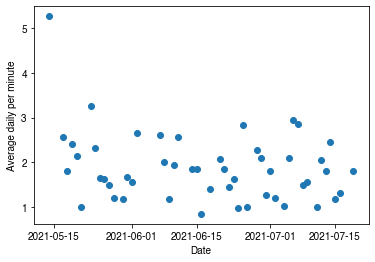

In [228]:
plt.plot(davg, marker='o', ls='')
plt.xlabel('Date')
plt.ylabel('Average daily per minute')

In [230]:
# try to figure out how to identify health related ads


In [245]:
try:
    annotation = json.loads(open('annotations.json')
except:
    annotation = dict()

In [ ]:


for idx, ad in enumerate(ad_content):
    if ad in annotation: continue
    print(idx, ad_content[ad])
    classification = input('1: other, 2: parenting, 3: health: ').strip()
    if classification == 'q':
        break
    annotation[ad] = classification
    f = open('annotations.json', 'w')
    f.write(json.dumps(annotation))
    f.close()

703 Latem wyzwól kreatywność! Zrób zakupy, odbierz torbę i odpimpuj ją po swojemu! Stacja Kreacja w Factory już 7-12.06! http://bit.ly/FA_StacjaKreacjaLatem wyzwól kreatywność! Zrób zakupy, odbierz torbę i odpimpuj ją po swojemu! Stacja Kreacja w Factory już 7-12.06! http://bit.ly/FA_StacjaKreacjaLikeComment
1: other, 2: parenting, 3: health: 1
704 The getaway you've been waiting for could cost less.The getaway you've been waiting for could cost less.JOINHONEY.COMThe Secret to Getting Reduced Prices On 2021 TravelThe Secret to Getting Reduced Prices On 2021 TravelThis tool helps unlock discounts on 30,000+ sites​LikeComment
1: other, 2: parenting, 3: health: 1
705 2021  Cruise Packages have never been this affordable! Incredible deals to paradise.  Explore the deals on top notch cruise packages now and save with these great deals. 2021  Cruise Packages have never been this affordable! Incredible deals to paradise.  Explore the deals on top notch cruise packages now and save with these 

1: other, 2: parenting, 3: health: 1
717  Czy wiesz czym tak naprawdę jest nadzór autorski, lub inaczej zastępstwo inwestorskie? Jeśli nie, a marzysz o pięknym i funkcjonalnym wnętrzu, idealnie dopasowanym do Twoich potrzeb, koniecznie przeczytaj artykuł na moim blogu.  Dowiesz się  z niego  … See more Czy wiesz czym tak naprawdę jest nadzór autorski, lub inaczej zastępstwo inwestorskie? Jeśli nie, a marzysz o pięknym i funkcjonalnym wnętrzu, idealnie dopasowanym do Twoich potrzeb, koniecznie przeczytaj artykuł na moim blogu.  Dowiesz się  z niego  … See morewww.prostyplan.pl Mieszkania do kochania Mieszkania do kochaniaCo można zrzucić na barki architekta zamawiając nadzór autorski?Open LinkLikeComment
1: other, 2: parenting, 3: health: 1
718 When was the last time you went on a vacation? After 2020, you deserve to go on about 365 vacations.Thankfully, by April, the majority of us will be vaccinated. This means it's time to make your safe, travel plans NOW.At Next Vacay, we deliver th

1: other, 2: parenting, 3: health: 1
728 You don't have to keep spending to keep caffeinated. Get our unlimited coffee subscription with your first three months FREE!You don't have to keep spending to keep caffeinated. Get our unlimited coffee subscription with your first three months FREE!panerabread.comYour cup is always fullYour cup is always fullTaxes and Restrictions applySubscribeLikeComment
1: other, 2: parenting, 3: health: 1
729 Odkryj naszą kolekcję Surfrider powstałą z myślą o ochronie mórz i oceanów! OKAIDI - moda francuska 0-14 lat Odkryj naszą kolekcję Surfrider powstałą z myślą o ochronie mórz i oceanów! OKAIDI - moda francuska 0-14 lat LikeComment
1: other, 2: parenting, 3: health: 1
730 Spróbuj szczęścia! Do wygrania aż 500 bezprzewodowych słuchawek oraz 100 głośników z funkcją Bluetooth. Ty wybierasz, o jaką nagrodę chcesz grać – ze wzorem Iron Mana lub Kapitana Ameryki! Loteria trwa od 24.05.2021 do 11.07.2021. Regulamin wraz z ilością nagród w danym wzorze znajdzies

1: other, 2: parenting, 3: health: 2
747 #colorvibes to nasze motto. Łącz i  miksuj modele i kolory. W końcu moda to także zabawa!#colorvibes to nasze motto. Łącz i  miksuj modele i kolory. W końcu moda to także zabawa!lamama.sklep.plLamama - Summer BasicLamama - Summer BasicProdukowane w Polsce w duchu społecznej odpowiedzialnościShop NowLikeComment
1: other, 2: parenting, 3: health: 1
748 Zosia ma 7 lat. Tutaj mieszka. Tak wygląda klatka schodowa w jej domu, a takie widoki towarzyszą jej każdego dnia.  Poczucie strachu, odrzucenie i samotność - to nie uczucia i emocje, jakie powinno czuć dziecko. W domu Zosi nikt nie ma dla niej czasu. Brakuje pieniędzy, ciepłego posiłku przy wspólnym stole, zabaw i czytania bajek na dobranoc. Zosia często wychodzi na podwórko - tutaj spędza większość czasu. Dzieci same nie szukają pomocy – nawet nie wiedzą, że jej potrzebują.… See moreZosia ma 7 lat. Tutaj mieszka. Tak wygląda klatka schodowa w jej domu, a takie widoki towarzyszą jej każdego dnia.  

1: other, 2: parenting, 3: health: 1
764 Level up in 2021Level up in 2021About this partnershipIGN.COMThis Top-Rated CompTIA Training Bundle Just Dropped Its Price to $69 For This Week OnlyThis Top-Rated CompTIA Training Bundle Just Dropped Its Price to $69 For This Week OnlyLikeComment
1: other, 2: parenting, 3: health: 1
765 Beautiful. Tremendously solid. Extremely detailed. So easy to set-up.See Displates – magnet-mounted Metal Posters of superior quality.Created for collectors. Made with passion.Buy yours now ►►► displate.com/get-inspiredBeautiful. Tremendously solid. Extremely detailed. So easy to set-up.See Displates – magnet-mounted Metal Posters of superior quality.Created for collectors. Made with passion.Buy yours now ►►► displate.com/get-inspiredVegeta blue soul Metal Poster$44Shop NowVegito dragon ball Metal Poster$44Shop NowDragon ball 84 Metal Poster$44Shop NowDark magician yugioh Metal Poster$44Shop NowDragon ball z kid buu Metal Poster$44Shop NowGoku Metal Poster$44Shop